<a href="https://colab.research.google.com/github/mirwisek/frame-selection-activenerf/blob/main/tiny_nerf_pytorch_rizwan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **For Rizwan**

## Tiny NeRF (A PyTorch implementation)

So, this weekend, I was catching up on this _cool paper_ titled [*NeRF: Representing scenes as neural radiance fields for view synthesis*](https://arxiv.org/abs/2003.08934)!

The authors released a TensorFlow implementation [here](https://github.com/bmild/nerf). Deciding to delve deeper, I ported their code to PyTorch, cause why not!

> *DISCLAIMER*: This notebook (and repository) is work-in-progress. Although I have rigorously tested most modules in here (to faithfully replicate the original implementation), my implementation at places deviates from the authors'. Comments/criticism welcome!

> All functions that have a `#TESTED` under the docstring imply that they have been tested against their corresponding tensorflow impls.

In [41]:
# !pip3 -q install umap-learn
# !pip3 -q install hdbscan
# !pip3 -q install lpips
# !pip3 -q install torchmetrics

In [42]:
# Import all the good stuff
import os
import torch
import numpy as np
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt
from pytorch3d.ops import box3d_overlap

In [43]:
from torch.nn.functional import pdist

## A few utility functions

In [44]:
from model import VeryTinyNerfModel
from image_encoder import ImageEncoder
from data_utils import load_tiny_nerf_data, load_nerf_data, get_focal_length
from utils import get_box_vertices, extract_features
from nerf_utils import positional_encoding

In [45]:
experiment_data_type = "tiny_nerf"
#experiment_data_type = "nerf_synthetic"
nerf_test_subject = "ship" 
nerf_subjects_list = ['ship', 'drums', 'ficus', 'hotdog', 'lego', 'materials', 'mic']

tiny_data_path = "data/tiny_nerf_data.npz"
nerf_synthetic_path = "data/nerf_synthetic"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logs_path = f"logs/{experiment_data_type}"

## Get data

In [46]:
# Download sample data used in the official tiny_nerf example
if not os.path.exists(tiny_data_path):
    !wget -P data/ http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

## Load up input images, poses, intrinsics, etc.

In [47]:
# Near and far clipping thresholds for depth values.
near_thresh = 2.
far_thresh = 6.

# Height and width of each image
height, width = 100, 100


if experiment_data_type == "tiny_nerf":
    images, tform_cam2world, focal_length, testimgs, testposes = load_tiny_nerf_data(tiny_data_path, device)
else:
    images, train_poses, camera_angle_x = load_nerf_data(nerf_synthetic_path, nerf_test_subject, 'transforms_train.json')
    tform_cam2world = train_poses

    focal_length = get_focal_length(width, camera_angle_x)
    focal_length = torch.from_numpy(focal_length).to(device)

    # Hold one image out (for test).
    testimgs, testposes, _ = load_nerf_data(nerf_synthetic_path, nerf_test_subject, 'transforms_test.json', skip_images=20)

    testimgs = testimgs.to(device)
    testposes = torch.from_numpy(testposes).to(device)

    # # Map images to device
    images = images.to(device)
    tform_cam2world = torch.from_numpy(tform_cam2world[:100,]).to(device)

#### Display the image used for testing

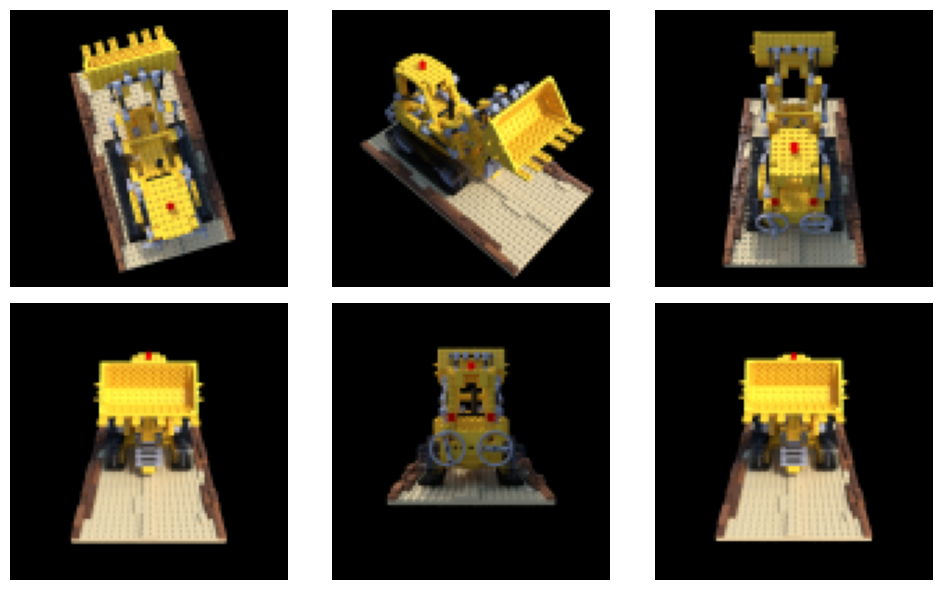

In [48]:
if experiment_data_type == "tiny_nerf":
    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
else:
    fig, axs = plt.subplots(2, 5, figsize=(10, 6))

# Loop through all axes and images
for ax, image in zip(axs.ravel(), testimgs):
    ax.imshow(image.detach().cpu().numpy(), cmap='viridis')  # You can change the colormap if needed
    ax.axis('off')  # Turn off axis

plt.tight_layout()
if experiment_data_type == "tiny_nerf":
    plt.savefig(f"{logs_path}/test_images.png")
else:
    #create folder for nerf test subject
    if not os.path.exists(f"{logs_path}/{nerf_test_subject}"):
        os.makedirs(f"{logs_path}/{nerf_test_subject}")
    plt.savefig(f"{logs_path}/{nerf_test_subject}/test_images_nerf.png")
plt.show()

## **Tiny NeRF Parameters**

In [49]:
# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 2000

# Misc parameters
display_every = 25  # Number of iters after which stats are displayed

model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [50]:
# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

In [51]:
def camera_position_from_extrinsic_matrix(extrinsic_matrix):
    """
    Calculate the camera position from the extrinsic matrix using PyTorch.

    :param extrinsic_matrix: A 3x4 or 4x4 extrinsic matrix of the camera
    :return: The position of the camera in world coordinates
    """
    # Extract the rotation matrix (R) and the translation vector (t)
    R = extrinsic_matrix[:3, :3]
    t = extrinsic_matrix[:3, 3]

    # Calculate the camera position: C = -R^-1 * t
    camera_position = -torch.inverse(R) @ t
    return camera_position

In [67]:
def select_diverse_images_per_cluster(tform_cam2world, labels, strategy, focal_length, k):
    """
    Select the most diverse image from each cluster based on cosine similarity.
    """
    unique_labels = set(labels)
    selected_indices = []

    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    items_per_cluster = k // n_clusters

    if items_per_cluster == 0:
        items_per_cluster = 1

    for label in unique_labels:

        if label == -1:
            continue  # Skip noise

        cluster_indices = [i for i, lbl in enumerate(labels) if lbl == label]
        

        if len(cluster_indices) > 1:
            
            if strategy == "fvs_distance":
                cluster_camera_pos = [camera_position_from_extrinsic_matrix(transform).detach().cpu().numpy() for transform in tform_cam2world[cluster_indices]] 
                torch_cc_pos = torch.tensor(cluster_camera_pos)
                pairwise_distances = torch.cdist(torch_cc_pos, torch_cc_pos, p=2.0)
                pairwise_distances_upper = torch.triu(pairwise_distances, diagonal=1)
                pairwise_distances_upper[pairwise_distances_upper==0] = -torch.inf
                _, top_indices = torch.topk(pairwise_distances_upper.flatten(), items_per_cluster, largest=True)
                max_pairwise_distances_indices = torch.cat((top_indices // len(cluster_indices), top_indices % len(cluster_indices)), dim=0)
                unique_indices = torch.unique(max_pairwise_distances_indices)
                selected_indices.extend([cluster_indices[idx] for idx in unique_indices])
            
            elif strategy == "fvs_iou_3d":

                boxes = []
                for idx in cluster_indices:
                    boxes.append(get_box_vertices(tform_cam2world[idx], focal_length))
                boxes = torch.stack(boxes, dim=0)
                _, iou_3d = box3d_overlap(boxes, boxes)
                iou_3d_upper = torch.triu(iou_3d, diagonal=1)
                iou_3d_upper[iou_3d_upper==0] = 2.0
                _, top_indices = torch.topk(iou_3d_upper.flatten(), items_per_cluster, largest=False)
                min_iou_3d_indices = torch.cat((top_indices // len(cluster_indices), top_indices % len(cluster_indices)), dim=0)
                unique_indices = torch.unique(min_iou_3d_indices)
                selected_indices.extend([cluster_indices[idx] for idx in unique_indices])
                
        else:
            selected_indices.append(cluster_indices[0])
        
    return selected_indices[:k]

In [68]:
def select_frames_based_on_strategy(images, focal_length, tform_cam2world, device, strategy = "random", embed_strategy = "fvs_distance", k = 10):
  

  if strategy == "random":

    indices = list(range(images.shape[0]))
    np.random.shuffle(indices)
    training_indices = indices[:k]
    training_images = images[training_indices]
    training_tforms = tform_cam2world[training_indices]

  elif strategy == "embedding":

    #best_dim_red_params = find_best_dim_red_params(images, embedding = "simple")
    embeddings = extract_features(images, device)
    #labels = DBSCAN(eps=0.7, min_samples=3).fit_predict(embeddings)
    #parameters = find_best_hdbscan_params(embeddings)
    labels = HDBSCAN(min_cluster_size=6, min_samples=2).fit_predict(embeddings)
    diverse_indices = select_diverse_images_per_cluster(tform_cam2world, labels, embed_strategy, focal_length, k)
    training_images = images[diverse_indices]
    training_tforms = tform_cam2world[diverse_indices]
  
  else:
    raise ValueError(f"Invalid strategy i.e. strategy = {strategy}. Valid strategies are: full, random, fvs, min_iou_3d, embedding")

  return training_images, training_tforms

/Users/rizwan/anaconda3/envs/albu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rizwan/anaconda3/envs/albu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


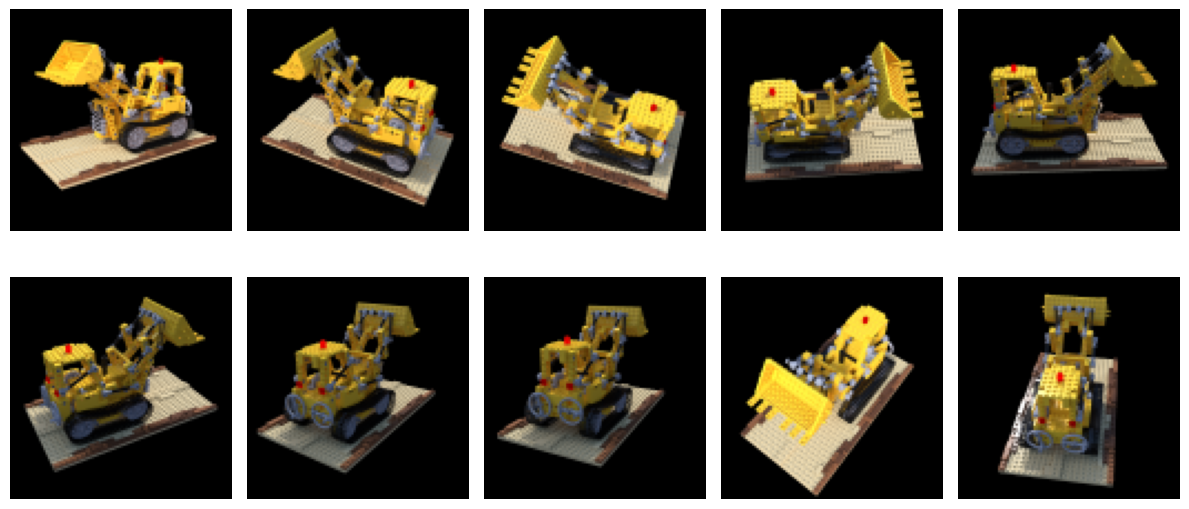

In [69]:
k = 10
strategy = "random" # "random" or "fvs" or "embedding"
training_images, training_tforms = select_frames_based_on_strategy(images, focal_length, tform_cam2world, device, "embedding", "fvs_distance", k)

fig, axs = plt.subplots(2, 5, figsize=(12, 6))

# Loop through all axes and images
for ax, image in zip(axs.ravel(), training_images):
    ax.imshow(image.detach().cpu().numpy(), cmap='viridis')  # You can change the colormap if needed
    ax.axis('off')  # Turn off axis

plt.tight_layout()
if experiment_data_type == "tiny_nerf":
    plt.savefig(f"{logs_path}/chosen_frames_using_{strategy}_strategy.png")
else:
    #create folder for nerf test subject
    if not os.path.exists(f"{logs_path}/{nerf_test_subject}"):
        os.makedirs(f"{logs_path}/{nerf_test_subject}")
    plt.savefig(f"{logs_path}/{nerf_test_subject}/chosen_frames_using_{strategy}_strategy.png")
plt.show()

/Users/rizwan/anaconda3/envs/albu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rizwan/anaconda3/envs/albu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/rizwan/anaconda3/envs/albu/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1702400154748/work/aten/src/ATen/native/TensorShape.cpp:3527.)
  

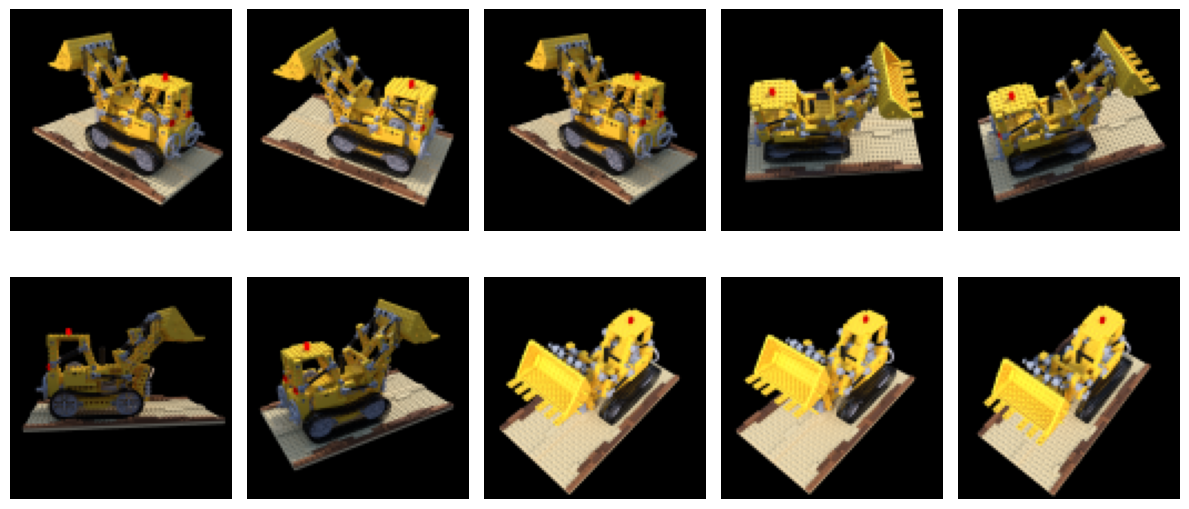

In [70]:
k = 10
strategy = "random" # "random" or "fvs" or "embedding"
training_images, training_tforms = select_frames_based_on_strategy(images, focal_length, tform_cam2world, device, "embedding", "fvs_iou_3d", k)

fig, axs = plt.subplots(2, 5, figsize=(12, 6))

# Loop through all axes and images
for ax, image in zip(axs.ravel(), training_images):
    ax.imshow(image.detach().cpu().numpy(), cmap='viridis')  # You can change the colormap if needed
    ax.axis('off')  # Turn off axis

plt.tight_layout()
if experiment_data_type == "tiny_nerf":
    plt.savefig(f"{logs_path}/chosen_frames_using_{strategy}_strategy.png")
else:
    #create folder for nerf test subject
    if not os.path.exists(f"{logs_path}/{nerf_test_subject}"):
        os.makedirs(f"{logs_path}/{nerf_test_subject}")
    plt.savefig(f"{logs_path}/{nerf_test_subject}/chosen_frames_using_{strategy}_strategy.png")
plt.show()

In [39]:
# import torch

# x = torch.tensor([[4, 2, 7, 1], [9, 22, 5, 13], [6, 4, 8, 25], [3, 9, 6, 10], [4, 1, 6, 14]])
# H, W = x.shape
# print(x)
# x = x.view(-1)
# print(x)
# K = 7
# _, indices = x.topk(K, largest=True)
# two_d_indices = torch.cat(((indices // W).unsqueeze(1), (indices % W).unsqueeze(1)), dim=1)
# print(two_d_indices)